In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import itertools
#import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical, set_random_seed

In [2]:
# Training Images
train_paths = glob.glob("training/**/*.jpg", recursive=True) # list of paths for all images in training folder
train_images = [cv2.imread(path, 0) for path in train_paths] # list of training images
train_labels = [path.split("\\")[1] for path in train_paths] # list of training image labels
# converting to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images: ", train_images.shape)
print("Shape of train_labels: ", train_labels.shape)
print("Number of Unique Labels: ", len(np.unique(train_labels)))

Shape of train_images:  (219, 75, 150)
Shape of train_labels:  (219,)
Number of Unique Labels:  4


In [3]:
# Validation Images
test_paths = glob.glob("validation/**/*.jpg", recursive=True) # list of paths for all images in validation folder
test_images = [cv2.imread(path, 0) for path in test_paths] # list of validation images
test_labels = [path.split("\\")[1] for path in test_paths] # list of validation image labels
# converting to numpy array
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images: ", test_images.shape)
print("Shape of test_labels: ", test_labels.shape)
print("Number of Unique Labels: ", len(np.unique(test_labels)))

Shape of test_images:  (80, 75, 150)
Shape of test_labels:  (80,)
Number of Unique Labels:  4


In [4]:
# Label Encoding Labels ['CR', 'CRP', 'CRT', 'CRTP'] -> [0 , 1, 2, 3]
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

In [5]:
x_train, y_train, x_test, y_test = train_images, train_labels_enc, test_images, test_labels_enc

In [6]:
def feature_extractor(image_list: np.ndarray, distances: list, angles: list):
    """ Extract Gray-Level Co-occerance Matrix (GLCM) Features 
        Parameters
        ----------
        image_list -> numpy array of images
        distances  -> list of distances (graycomatrix parameter) 
        angles     -> list of angles    (graycomatrix parameter)

        Returns
        ----------
        Pandas Dataframe of Image features of size I  * (D * A) where,
        I -> Number of images
        D -> Number of distances
        A -> Number of Angles
    """
    img_features_df = pd.DataFrame() # empty dataframe to append feature values
    
    # iterate through each image
    for img in image_list:
        df = pd.DataFrame() # empty dataframe store feature values for 'img' 
        params = list(itertools.product(distances, angles)) # possible pairs of distances and angles
        # glcm_features = ["energy", "correlation", "dissimilarity", "homogeinity", "contrast", "ASM"]

        # iterate for each distance and angle pair, calculate glcm and extract features
        for (d, ang) in params:
            GLCM = graycomatrix(img, [d], [np.deg2rad(ang)])
            df["Correlation_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "correlation")[0]
            df["Dissimilarity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "dissimilarity")[0]
            df["Homogeneity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "homogeneity")[0]
            df["Contrast_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "contrast")[0]
            df["ASM_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "ASM")[0]
            df["Energy_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "energy")[0]
        
        img_features_df =  pd.concat([img_features_df, df], ignore_index=True) # append extracted features

    return img_features_df

In [7]:
# Define GLCM Features parameters distances and angles
dists = [1, 2, 3, 4] # distances
angs  = [0, 45, 90, 135] # angles

In [8]:
x_features = feature_extractor(x_train, dists, angs) # generate glcm features for training data
scaler = StandardScaler()
x_features[x_features.columns] = scaler.fit_transform(x_features[x_features.columns]) # Scaling Features

In [9]:
print("Shape of GLCM Features for Training: ", x_features.shape)
x_features

Shape of GLCM Features for Training:  (219, 96)


,Correlation_1_0,Dissimilarity_1_0,Homogeneity_1_0,Contrast_1_0,ASM_1_0,Energy_1_0,Correlation_1_45,Dissimilarity_1_45,Homogeneity_1_45,Contrast_1_45,...,Homogeneity_4_90,Contrast_4_90,ASM_4_90,Energy_4_90,Correlation_4_135,Dissimilarity_4_135,Homogeneity_4_135,Contrast_4_135,ASM_4_135,Energy_4_135
0,-1.346732,-1.021034,0.640791,-1.046796,1.566989,1.570450,-1.422533,-1.114552,0.692316,-1.147336,...,1.680940,-1.473384,2.178928,2.146077,-0.842129,-1.650088,1.668827,-1.464744,2.198839,2.167608
1,-1.049394,-1.745044,1.726539,-1.479578,3.307186,2.981924,-1.126798,-1.839865,1.915676,-1.599434,...,1.957926,-1.684936,3.714809,3.386047,-1.254564,-2.092762,2.674905,-1.728029,3.743329,3.414899
2,-0.459369,-1.613520,1.627818,-1.353202,2.566844,2.406780,-0.476775,-1.650995,1.746900,-1.458420,...,1.989357,-1.468925,2.636364,2.530782,-1.294781,-1.705368,1.837474,-1.464184,2.665269,2.559930
3,-1.057850,-0.294171,-0.270474,-0.501637,0.271275,0.350292,-1.205279,-0.354418,-0.106020,-0.531911,...,0.286125,-0.809854,0.651190,0.738183,-0.642553,-0.947486,0.752235,-0.957358,0.674427,0.762755
4,-2.040004,-1.043052,0.568494,-1.013158,1.779739,1.754940,-1.997290,-1.166219,0.866489,-1.160251,...,2.022066,-1.520107,2.416144,2.347376,-1.250765,-1.728114,1.384132,-1.522804,2.472746,2.399801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.531336,-0.470648,0.150216,-0.465452,-0.270207,-0.222437,0.690347,-0.559053,0.119401,-0.572888,...,-0.106218,-0.480077,-0.383352,-0.362790,0.694402,-0.260545,-0.094115,-0.381406,-0.373517,-0.352611
215,0.420237,-0.386346,0.132469,-0.438787,-0.184551,-0.128754,0.504667,-0.482866,0.159257,-0.510373,...,0.216505,-0.366571,-0.250936,-0.213085,0.392066,-0.258577,-0.072605,-0.381065,-0.258792,-0.222632
216,0.953899,-1.079506,0.922161,-1.079307,0.220577,0.298521,0.965420,-1.063047,0.954259,-1.100778,...,0.349173,-0.862123,-0.065058,-0.007716,0.634128,-0.668554,0.186434,-0.805210,-0.094591,-0.040324
217,0.610613,-0.530390,0.357580,-0.597147,-0.282245,-0.235704,0.569752,-0.454767,-0.004804,-0.568511,...,0.108451,-0.419951,-0.372376,-0.350269,0.312249,-0.249502,-0.078918,-0.375069,-0.332288,-0.305645


In [10]:
# Predict on Test data
# Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test, dists, angs)
test_features[test_features.columns] = scaler.transform(test_features[test_features.columns]) # Scaling Features

In [11]:
print("Shape of GLCM Features for Validation: ", test_features.shape)

Shape of GLCM Features for Validation:  (80, 96)


In [12]:
# ANN CONSTRUCTION
set_random_seed(14)
in_dim = x_features.shape[1]
ann = Sequential()
ann.add(Dense(units=25, input_dim= in_dim, activation='relu'))
ann.add(Dense(units=15, activation='relu'))
ann.add(Dense(units=8, activation='relu'))
ann.add(Dense(units=4, activation='softmax'))
ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit training data
ann.fit(x_features, to_categorical(train_labels_enc), epochs=150, batch_size=5)
# Evalute model on test data
scores = ann.evaluate(test_features, to_categorical(test_labels_enc))
print(f"\nloss: {round(scores[0], 3)} \t accuracy: {round(scores[1], 3)}") # Print loss and accuracy



Epoch 1/150


44/44 [==============================] - 2s 4ms/step - loss: 1.2456 - accuracy: 0.3927
Epoch 2/150
44/44 [==============================] - 0s 4ms/step - loss: 1.0824 - accuracy: 0.4886
Epoch 3/150
44/44 [==============================] - 0s 4ms/step - loss: 0.9994 - accuracy: 0.5434
Epoch 4/150
44/44 [==============================] - 0s 3ms/step - loss: 0.9133 - accuracy: 0.5571
Epoch 5/150
44/44 [==============================] - 0s 4ms/step - loss: 0.8737 - accuracy: 0.5571
Epoch 6/150
44/44 [==============================] - 0s 4ms/step - loss: 0.8389 - accuracy: 0.5982
Epoch 7/150
44/44 [==============================] - 0s 3ms/step - loss: 0.8201 - accuracy: 0.5982
Epoch 8/150
44/44 [==============================] - 0s 3ms/step - loss: 0.7865 - accuracy: 0.6712
Epoch 9/150
44/44 [==============================] - 0s 3ms/step - loss: 0.7898 - accuracy: 0.6849
Epoch 10/150
44/44 [==============================] - 0s 4ms/step - loss: 0.7395 - accuracy: 0.7169
Epoch

In [13]:
# Predict on test data
test_prediction = ann.predict(test_features)

3/3 [==============================] - 0s 5ms/step


In [14]:
test_prediction=np.argmax(test_prediction, axis=1) # get the class with the highest probability value
test_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [15]:
# Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)
test_prediction # predicted labels for test images

array(['CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR',
       'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP'], dtype='<U4')

In [16]:
test_labels # True labels of test images

array(['CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR',
       'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CR', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP', 'CRP',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT', 'CRT',
       'CRT', 'CRT', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP',
       'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP', 'CRTP'], dtype='<U4')

In [17]:
# Accuracy
print ("Accuracy:", metrics.accuracy_score(test_labels, test_prediction))

Accuracy: 1.0


In [18]:
# Precision 
print("Precision:\n[CR, CRP, CRT, CRTP]\t", metrics.precision_score(test_labels, test_prediction, average=None))

Precision:
[CR, CRP, CRT, CRTP]	 [1. 1. 1. 1.]


In [19]:
# Recall
print("Recall:\n[CR, CRP, CRT, CRTP]\t", metrics.recall_score(test_labels, test_prediction, average=None))

Recall:
[CR, CRP, CRT, CRTP]	 [1. 1. 1. 1.]


In [20]:
# F1 score
print("F1 Scores:\n[CR, CRP, CRT, CRTP]\t", metrics.f1_score(test_labels, test_prediction, average=None))

F1 Scores:
[CR, CRP, CRT, CRTP]	 [1. 1. 1. 1.]


In [21]:
def gen_annotations(cf_matrix):
    """
    Generates Annotation for each cell in confusion matrix
    args:
        cf_matrix: confusion matrix (numpy array)
    """
    sums = np.sum(cf_matrix, axis=1, keepdims=True) # sum of each row
    cf_perc = 100*cf_matrix/sums # converting to percentage
    annot = np.empty_like(cf_matrix).astype(str) # creating a empty numpy array to store annotations for each cell
    # iterate through each cell and store the annotation
    rows, cols = cf_matrix.shape 
    for i in range(rows):
        for j in range(cols):
            val = cf_matrix[i, j]
            perc_val = cf_perc[i, j]
            if val == 0: 
                annot[i, j] = '0'
            else:
                sum_val = sums[i][0]
                annot[i, j] = "%.1f%%\n(%d/%d)" % (perc_val, val, sum_val)
    return annot   

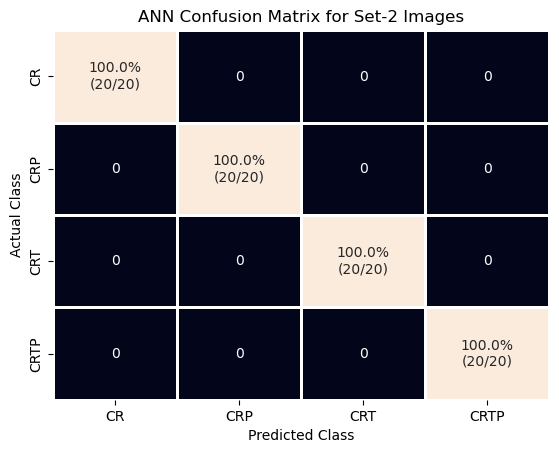

In [22]:
# Plot confusion matrix
cm = metrics.confusion_matrix(test_labels, test_prediction)
annot = gen_annotations(cm)
fig = sns.heatmap(cm, annot=annot, fmt='', cbar=False, linewidth=1,
            xticklabels=['CR', 'CRP', 'CRT', 'CRTP'],
            yticklabels=['CR', 'CRP', 'CRT', 'CRTP']).get_figure()

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('ANN Confusion Matrix for Set-2 Images')
plt.show()
fig.savefig("plots/ann/cfmatrix_ann_set_2.png", dpi=600)

## Shap Analysis

In [22]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [23]:
# get shap values
shap_values = shap.KernelExplainer(ann.predict, x_features).shap_values(test_features)

7/7 [==============================] - 0s 3ms/step


Using 219 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/80 [00:00<?, ?it/s]

15330/15330 [==============================] - 48s 3ms/step


  1%|▏         | 1/80 [01:15<1:39:07, 75.28s/it]

15330/15330 [==============================] - 45s 3ms/step


  2%|▎         | 2/80 [02:20<1:30:23, 69.54s/it]

15330/15330 [==============================] - 48s 3ms/step


  4%|▍         | 3/80 [03:28<1:28:19, 68.82s/it]

15330/15330 [==============================] - 46s 3ms/step


  5%|▌         | 4/80 [04:34<1:25:38, 67.61s/it]

15330/15330 [==============================] - 52s 3ms/step


  6%|▋         | 5/80 [05:49<1:27:39, 70.12s/it]

15330/15330 [==============================] - 54s 3ms/step


  8%|▊         | 6/80 [07:05<1:28:59, 72.15s/it]

15330/15330 [==============================] - 48s 3ms/step


  9%|▉         | 7/80 [08:14<1:26:38, 71.21s/it]

15330/15330 [==============================] - 47s 3ms/step


 10%|█         | 8/80 [09:23<1:24:36, 70.51s/it]

15330/15330 [==============================] - 52s 3ms/step


 11%|█▏        | 9/80 [10:37<1:24:48, 71.67s/it]

15330/15330 [==============================] - 47s 3ms/step


 12%|█▎        | 10/80 [11:46<1:22:33, 70.76s/it]

15330/15330 [==============================] - 51s 3ms/step


 14%|█▍        | 11/80 [13:05<1:24:19, 73.33s/it]

15330/15330 [==============================] - 57s 4ms/step


 15%|█▌        | 12/80 [14:29<1:26:43, 76.53s/it]

15330/15330 [==============================] - 45s 3ms/step


 16%|█▋        | 13/80 [15:37<1:22:35, 73.97s/it]

15330/15330 [==============================] - 46s 3ms/step


 18%|█▊        | 14/80 [16:43<1:18:51, 71.69s/it]

15330/15330 [==============================] - 46s 3ms/step


 19%|█▉        | 15/80 [17:50<1:16:01, 70.18s/it]

15330/15330 [==============================] - 46s 3ms/step


 20%|██        | 16/80 [18:57<1:13:50, 69.23s/it]

15330/15330 [==============================] - 45s 3ms/step


 21%|██▏       | 17/80 [20:04<1:11:48, 68.39s/it]

15330/15330 [==============================] - 51s 3ms/step


 22%|██▎       | 18/80 [21:19<1:12:45, 70.41s/it]

15330/15330 [==============================] - 55s 4ms/step


 24%|██▍       | 19/80 [22:38<1:14:12, 72.99s/it]

15330/15330 [==============================] - 53s 3ms/step


 25%|██▌       | 20/80 [23:55<1:14:15, 74.26s/it]

15330/15330 [==============================] - 49s 3ms/step


 26%|██▋       | 21/80 [25:09<1:13:03, 74.30s/it]

15330/15330 [==============================] - 58s 4ms/step


 28%|██▊       | 22/80 [26:32<1:14:24, 76.97s/it]

15330/15330 [==============================] - 48s 3ms/step


 29%|██▉       | 23/80 [27:44<1:11:42, 75.48s/it]

15330/15330 [==============================] - 49s 3ms/step


 30%|███       | 24/80 [28:57<1:09:43, 74.70s/it]

15330/15330 [==============================] - 56s 4ms/step


 31%|███▏      | 25/80 [30:17<1:09:51, 76.21s/it]

15330/15330 [==============================] - 50s 3ms/step


 32%|███▎      | 26/80 [31:31<1:07:53, 75.44s/it]

15330/15330 [==============================] - 49s 3ms/step


 34%|███▍      | 27/80 [32:43<1:05:42, 74.39s/it]

15330/15330 [==============================] - 50s 3ms/step


 35%|███▌      | 28/80 [34:01<1:05:26, 75.50s/it]

15330/15330 [==============================] - 56s 4ms/step


 36%|███▋      | 29/80 [35:22<1:05:30, 77.07s/it]

15330/15330 [==============================] - 58s 4ms/step


 38%|███▊      | 30/80 [36:48<1:06:41, 80.03s/it]

15330/15330 [==============================] - 62s 4ms/step


 39%|███▉      | 31/80 [38:16<1:07:18, 82.41s/it]

15330/15330 [==============================] - 57s 4ms/step


 40%|████      | 32/80 [39:36<1:05:12, 81.52s/it]

15330/15330 [==============================] - 47s 3ms/step


 41%|████▏     | 33/80 [40:44<1:00:38, 77.42s/it]

15330/15330 [==============================] - 54s 3ms/step


 42%|████▎     | 34/80 [42:06<1:00:22, 78.76s/it]

15330/15330 [==============================] - 51s 3ms/step


 44%|████▍     | 35/80 [43:21<58:19, 77.76s/it]  

15330/15330 [==============================] - 49s 3ms/step


 45%|████▌     | 36/80 [44:32<55:35, 75.82s/it]

15330/15330 [==============================] - 47s 3ms/step


 46%|████▋     | 37/80 [45:41<52:48, 73.69s/it]

15330/15330 [==============================] - 48s 3ms/step


 48%|████▊     | 38/80 [46:51<50:53, 72.71s/it]

15330/15330 [==============================] - 47s 3ms/step


 49%|████▉     | 39/80 [48:00<48:55, 71.59s/it]

15330/15330 [==============================] - 46s 3ms/step


 50%|█████     | 40/80 [49:09<47:09, 70.74s/it]

15330/15330 [==============================] - 48s 3ms/step


 51%|█████▏    | 41/80 [50:18<45:42, 70.31s/it]

15330/15330 [==============================] - 55s 4ms/step


 52%|█████▎    | 42/80 [51:39<46:23, 73.26s/it]

15330/15330 [==============================] - 56s 4ms/step


 54%|█████▍    | 43/80 [52:58<46:20, 75.14s/it]

15330/15330 [==============================] - 52s 3ms/step


 55%|█████▌    | 44/80 [54:14<45:09, 75.26s/it]

15330/15330 [==============================] - 44s 3ms/step


 56%|█████▋    | 45/80 [55:18<41:59, 71.99s/it]

15330/15330 [==============================] - 45s 3ms/step


 57%|█████▊    | 46/80 [56:26<40:02, 70.66s/it]

15330/15330 [==============================] - 49s 3ms/step


 59%|█████▉    | 47/80 [57:47<40:40, 73.97s/it]

15330/15330 [==============================] - 53s 3ms/step


 60%|██████    | 48/80 [59:04<39:56, 74.89s/it]

15330/15330 [==============================] - 53s 3ms/step


 61%|██████▏   | 49/80 [1:00:21<39:00, 75.49s/it]

15330/15330 [==============================] - 52s 3ms/step


 62%|██████▎   | 50/80 [1:01:37<37:51, 75.70s/it]

15330/15330 [==============================] - 53s 3ms/step


 64%|██████▍   | 51/80 [1:02:53<36:33, 75.64s/it]

15330/15330 [==============================] - 44s 3ms/step


 65%|██████▌   | 52/80 [1:03:57<33:42, 72.22s/it]

15330/15330 [==============================] - 44s 3ms/step


 66%|██████▋   | 53/80 [1:05:01<31:21, 69.68s/it]

15330/15330 [==============================] - 45s 3ms/step


 68%|██████▊   | 54/80 [1:06:05<29:24, 67.85s/it]

15330/15330 [==============================] - 45s 3ms/step


 69%|██████▉   | 55/80 [1:07:08<27:41, 66.46s/it]

15330/15330 [==============================] - 42s 3ms/step


 70%|███████   | 56/80 [1:08:08<25:53, 64.71s/it]

15330/15330 [==============================] - 41s 3ms/step


 71%|███████▏  | 57/80 [1:09:09<24:21, 63.53s/it]

15330/15330 [==============================] - 47s 3ms/step


 72%|███████▎  | 58/80 [1:10:17<23:47, 64.87s/it]

15330/15330 [==============================] - 51s 3ms/step


 74%|███████▍  | 59/80 [1:11:28<23:18, 66.60s/it]

15330/15330 [==============================] - 44s 3ms/step


 75%|███████▌  | 60/80 [1:12:31<21:52, 65.63s/it]

15330/15330 [==============================] - 46s 3ms/step


 76%|███████▋  | 61/80 [1:13:37<20:49, 65.78s/it]

15330/15330 [==============================] - 50s 3ms/step


 78%|███████▊  | 62/80 [1:14:50<20:20, 67.79s/it]

15330/15330 [==============================] - 51s 3ms/step


 79%|███████▉  | 63/80 [1:16:01<19:30, 68.86s/it]

15330/15330 [==============================] - 48s 3ms/step


 80%|████████  | 64/80 [1:17:09<18:17, 68.60s/it]

15330/15330 [==============================] - 45s 3ms/step


 81%|████████▏ | 65/80 [1:18:15<16:55, 67.68s/it]

15330/15330 [==============================] - 52s 3ms/step


 82%|████████▎ | 66/80 [1:19:31<16:25, 70.43s/it]

15330/15330 [==============================] - 57s 4ms/step


 84%|████████▍ | 67/80 [1:20:54<16:01, 73.98s/it]

15330/15330 [==============================] - 57s 4ms/step


 85%|████████▌ | 68/80 [1:22:16<15:15, 76.33s/it]

15330/15330 [==============================] - 56s 4ms/step


 86%|████████▋ | 69/80 [1:23:37<14:16, 77.87s/it]

15330/15330 [==============================] - 56s 4ms/step


 88%|████████▊ | 70/80 [1:24:58<13:06, 78.69s/it]

15330/15330 [==============================] - 56s 4ms/step


 89%|████████▉ | 71/80 [1:26:19<11:55, 79.51s/it]

15330/15330 [==============================] - 55s 4ms/step


 90%|█████████ | 72/80 [1:27:39<10:37, 79.75s/it]

15330/15330 [==============================] - 55s 4ms/step


 91%|█████████▏| 73/80 [1:28:59<09:17, 79.70s/it]

15330/15330 [==============================] - 54s 4ms/step


 92%|█████████▎| 74/80 [1:30:17<07:55, 79.32s/it]

15330/15330 [==============================] - 54s 3ms/step


 94%|█████████▍| 75/80 [1:31:36<06:35, 79.03s/it]

15330/15330 [==============================] - 54s 4ms/step


 95%|█████████▌| 76/80 [1:32:55<05:15, 78.98s/it]

15330/15330 [==============================] - 53s 3ms/step


 96%|█████████▋| 77/80 [1:34:13<03:56, 78.77s/it]

15330/15330 [==============================] - 54s 4ms/step


 98%|█████████▊| 78/80 [1:35:32<02:37, 78.76s/it]

15330/15330 [==============================] - 54s 4ms/step


 99%|█████████▉| 79/80 [1:36:50<01:18, 78.63s/it]

15330/15330 [==============================] - 54s 4ms/step


100%|██████████| 80/80 [1:38:09<00:00, 73.62s/it]


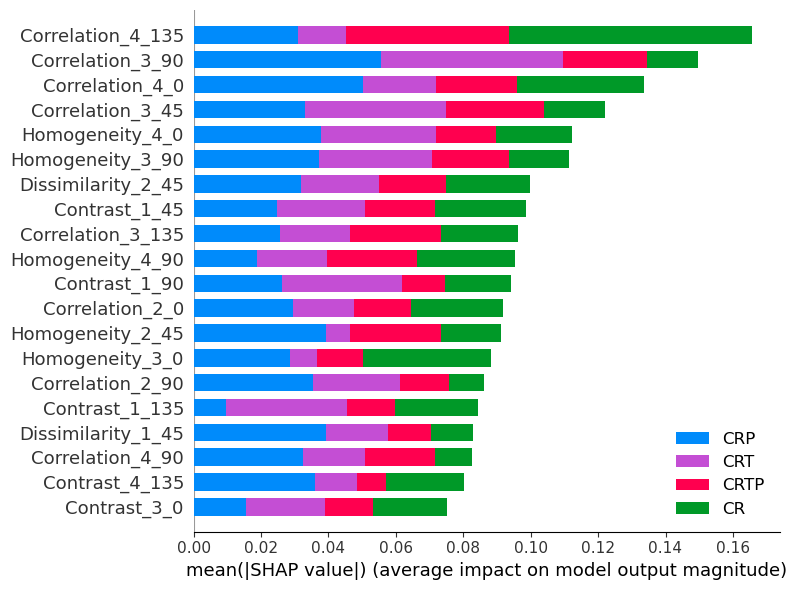

In [24]:
# plot summary
shap.summary_plot(shap_values, test_features, class_names=["CR", "CRP", "CRT", "CRTP"], plot_size=[8,6], show=False)
plt.savefig("plots/ann/shap_summary_all.png", dpi=600)

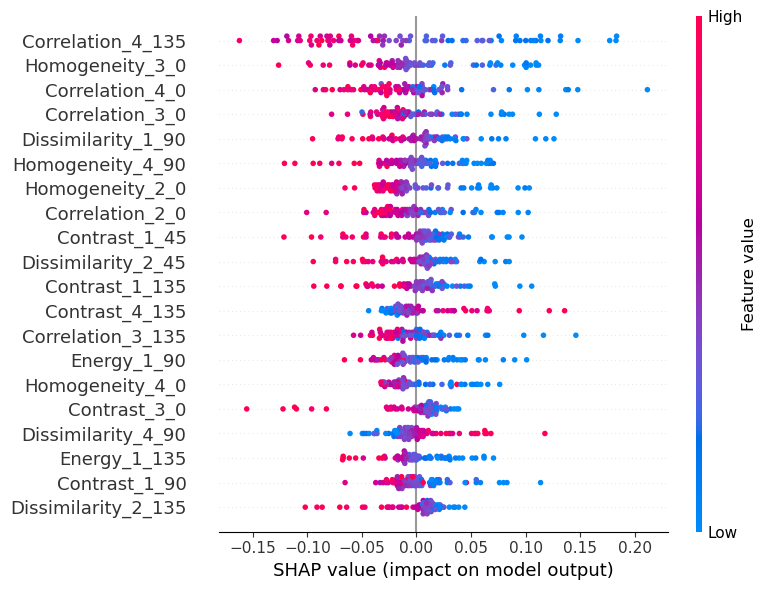

In [25]:
shap.summary_plot(shap_values[0], test_features, plot_size=[8,6], show=False) # summary plot for 'CR' class
plt.savefig("plots/ann/shap_summary_CR.png", dpi=600)

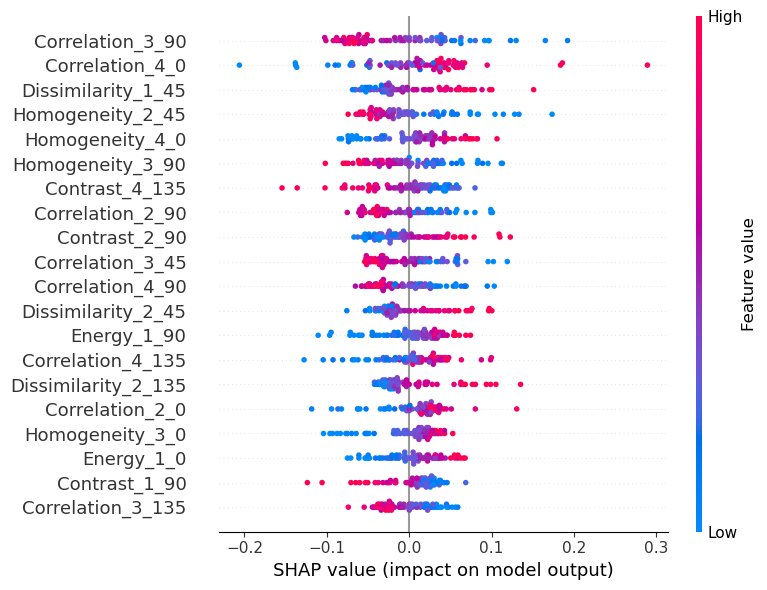

In [26]:
shap.summary_plot(shap_values[1], test_features, plot_size=[8,6], show=False) # summary plot for 'CRP' class
plt.savefig("plots/ann/shap_summary_CRP.png", dpi=600)

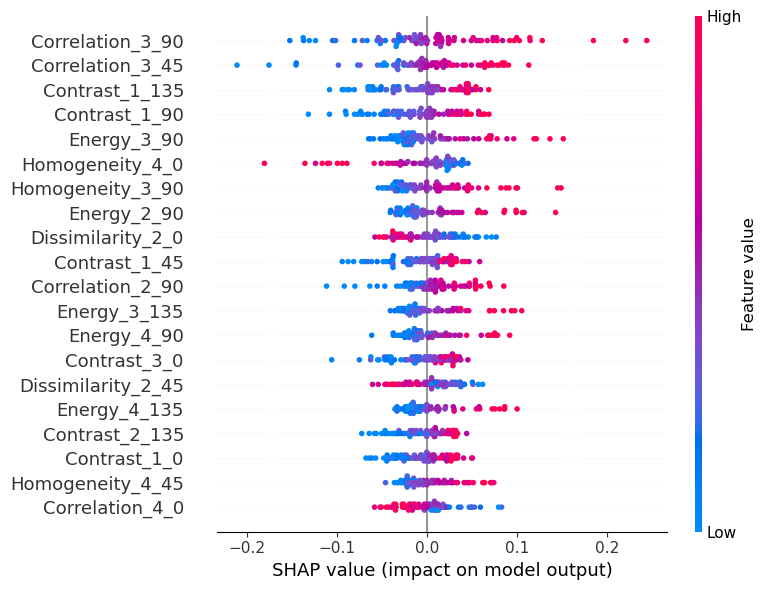

In [27]:
shap.summary_plot(shap_values[2], test_features, plot_size=[8,6], show=False) # summary plot for 'CRT' class
plt.savefig("plots/ann/shap_summary_CRT.png", dpi=600)

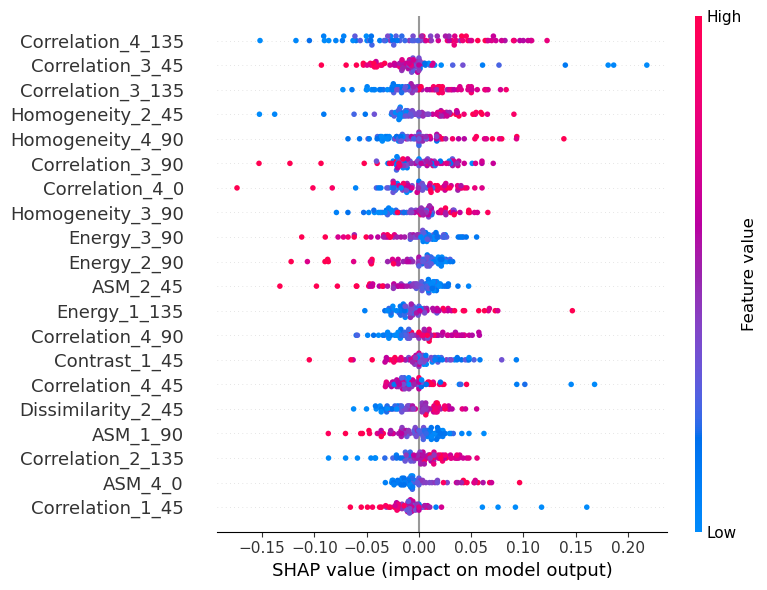

In [28]:
shap.summary_plot(shap_values[3], test_features, plot_size=[8,6], show=False) # summary plot for 'CRTP' class
plt.savefig("plots/ann/shap_summary_CRTP.png", dpi=600)

## Cross Validation

In [29]:
# Accumulate all the training and test image features and labels
all_features = pd.concat([x_features, test_features], ignore_index=True)
all_labels_enc = np.append(train_labels_enc, test_labels_enc)

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
acc_per_fold = []

# iterate through each fold
for train_idx, test_idx in kf.split(all_features):
    X_train, X_test = all_features.iloc[train_idx], all_features.iloc[test_idx]
    y_train, y_test = all_labels_enc[train_idx], all_labels_enc[test_idx]
    # Fit training data
    ann.fit(X_train, to_categorical(y_train), epochs=150, batch_size=5, verbose=0)
    # Evalute model on test data
    scores = ann.evaluate(X_test, to_categorical(y_test), verbose=0)
    # predict using ann
    y_pred = ann.predict(X_test)
    # get the class with the highest probability
    y_pred_labels = np.argmax(y_pred, axis=1)
    # Calculate accuracy
    acc = metrics.accuracy_score(y_test, y_pred_labels)
    acc_per_fold.append(acc)

1/1 [==============================] - 0s 53ms/step


In [31]:
# Average Accuracy Score
avg_accuracy =  np.mean(acc_per_fold)
print(f'Average Accuracy: {avg_accuracy:.4f}')

Average Accuracy: 0.9900
